In [1]:
# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from functools import partial
from pathlib import Path
from pprint import pprint as ppr

from box import Box

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Computation & ML libraries.
import numpy as np
import sklearn
import sklearn.svm, sklearn.pipeline, sklearn.decomposition, sklearn.preprocessing, sklearn.ensemble
import einops
import pandas as pd

import mne

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)

In [2]:
rng = np.random.default_rng()

In [3]:
EEG_EPOCH_DATASET_F = Path("preproc_eeg_pushbutton_epochs.npz")
assert EEG_EPOCH_DATASET_F.exists()

SUBJ_IDS = ("S001", "S002", "S003")
# SUBJ_IDS = ("S001",)

eeg_data = Box(**np.load(EEG_EPOCH_DATASET_F), frozen_box=True)

In [4]:
# fmt: off
CHANNELS = (
    'Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3',
    'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1',
    'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz',
    'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2',
    'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1',
    'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz',
    'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6',
    'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'Iz',
)
# fmt: on

## Train/Test Split

In [5]:
PUSH = 1
NO_PUSH = 0

# Designate some number of push events as the test set.
N_TEST_EPOCHS_PER_SUBJ = 3
N_NEGATIVE_TRAIN_SAMPLES_PER_SUBJ_EPOCH = 20
N_NEGATIVE_TEST_SAMPLES_PER_SUBJ_EPOCH = 100

WINDOW_LEN_TIME = 1.5  # seconds
EDGE_WINDOW_BACKOFF_SAMPLES = 2

sample_dt = np.round(np.median(np.diff(eeg_data.times)), decimals=5)
sample_freq = sample_dt**-1
window_len_samples = math.floor(WINDOW_LEN_TIME / sample_dt)

# Normalize features within subject x electrode.
# preproc_scaler = sklearn.preprocessing.RobustScaler(quantile_range=(10.0, 90.0))
# preproc_scaler_default_params = preproc_scaler.get_params(deep=True)

preproc_scaler = None
if preproc_scaler is None:
    preproc_scaler_default_params = None

In [14]:
N_FREQS = 50
freqs = np.logspace(
    np.log10(WINDOW_LEN_TIME**-1),
    np.log10((sample_freq / 2) - 1),
    num=N_FREQS,
)
# target_gaussian_envelope_sigma = 0.1
# target_fwhm = target_gaussian_envelope_sigma * 2 * np.sqrt(2 * np.log(2))
def calc_ncycles(freqs, target_fwhm):
    return target_fwhm * np.pi * np.array(freqs) / np.sqrt(2 * np.log(2))


# n_cycles = calc_ncycles(freqs, target_fwhm=target_fwhm)
n_cycles = WINDOW_LEN_TIME * freqs
# n_cycles = 1 * np.ones_like(freqs)
print(freqs)
print(n_cycles)
print(n_cycles / freqs)

compute_tfr_from_epochs = partial(
    mne.time_frequency.tfr_array_morlet,
    sfreq=sample_freq,
    freqs=np.array(freqs).copy(),
    n_cycles=np.array(n_cycles).copy(),
    use_fft=True,
    output="power",
    verbose=True,
)

[  0.66666667   0.74169497   0.82516713   0.91803347   1.0213512    1.13629657
   1.26417817   1.40645187   1.56473741   1.74083679   1.93675483   2.15472196
   2.39721965   2.66700862   2.96716031   3.3010918    3.67260475   4.08592869
   4.54576911   5.05736111   5.62652891   6.25975226   6.96424011   7.74801276
   8.61999309   9.59010823  10.6694025   11.87016319  13.20606044  14.69230283
  16.34581058  18.18540814  20.23203852  22.5090017   25.04221989  27.86053266
  30.99602526  34.48439387  38.36535203  42.68308272  47.48674141  52.83101562
  58.77674753  65.39162668  72.75096053  80.93853184  90.04755248 100.18172462
 111.45642132 124.        ]
[  1.           1.11254245   1.2377507    1.3770502    1.5320268    1.70444485
   1.89626725   2.10967781   2.34710612   2.61125519   2.90513225   3.23208295
   3.59582948   4.00051294   4.45074046   4.9516377    5.50890713   6.12889304
   6.81865367   7.58604166   8.43979337   9.38962839  10.44636017  11.62201913
  12.92998964  14.385162

In [15]:
# Create TFRs for each subject and epoch
subj_tfrs = Box(default_box=False)
# The number of samples that will be effected by an edge effect.
n_samples_edge_effect = math.ceil(window_len_samples / 2)

for subj_id in SUBJ_IDS:
    print(subj_id)
    # epoch x channel x time
    eeg_ep_ch_t = eeg_data[subj_id]
    tfr_ep_ch_f_t = compute_tfr_from_epochs(eeg_ep_ch_t)
    # Back off edge effects
    tfr_ep_ch_f_t = tfr_ep_ch_f_t[..., n_samples_edge_effect:-n_samples_edge_effect]
    subj_tfrs[subj_id] = tfr_ep_ch_f_t

subj_tfrs.times = eeg_data.times[n_samples_edge_effect:-n_samples_edge_effect]
subj_tfrs = Box(**subj_tfrs.to_dict(), frozen_box=True)

S001


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


S002


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


S003


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]), [Text(-10.0, 0, '−10'), Text(0.0, 0, '0'), Text(10.0, 0, '10'), Text(20.0, 0, '20'), Text(30.0, 0, '30'), Text(40.0, 0, '40'), Text(50.0, 0, '50')])


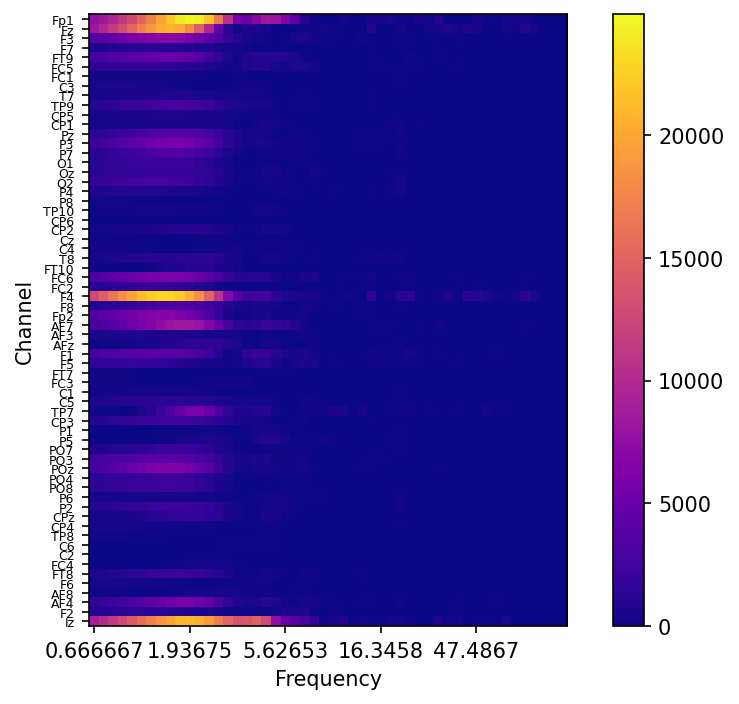

In [23]:
# tfr = mne.time_frequency.tfr_array_morlet(
#     eeg_data.S001,
#     sfreq=sample_freq,
#     freqs=freqs,
#     n_cycles=n_cycles,
#     use_fft=True,
#     output="power",
#     verbose=True
# )

tfr = subj_tfrs.S002
select_tfr = tfr[1, :, :, -1]
plt.figure(dpi=150)
plt.imshow(select_tfr, cmap="plasma")  # , norm=mpl.colors.PowerNorm(gamma=np.e))
plt.xlabel("Frequency")
plt.ylabel("Channel")
plt.yticks(np.arange(len(CHANNELS)), CHANNELS, fontsize=6.0)
print(plt.xticks())
plt.xticks(
    np.arange(0, N_FREQS, 10),
    [f"{f:g}" for f in freqs[np.arange(0, N_FREQS, 10)]],
)
# plt.xscale('log')
plt.colorbar();

In [18]:
# Test set creation
# Mask to indicate which epochs are valid for the training set.
epochs_for_train_set_mask = {
    k: np.ones(eeg_data[k].shape[0]).astype(bool) for k in SUBJ_IDS
}

x_test = list()
y_test = list()
test_subj_id = list()
test_epoch_idx = list()

for subj_id in SUBJ_IDS:
    tfrs_ep_ch_f_t = subj_tfrs[subj_id]
    n_epochs = tfrs_ep_ch_f_t.shape[0]
    n_freqs = tfrs_ep_ch_f_t.shape[-2]

    test_epochs = rng.choice(
        np.arange(n_epochs), size=N_TEST_EPOCHS_PER_SUBJ, replace=False
    )
    # Optionally scale the data.
    if preproc_scaler is not None:
        # Reset parameters of scaler.
        preproc_scaler.set_params(**preproc_scaler_default_params)
        # The test set may use distribution information across *all* epochs, but the
        # training set may not.
        scaled_tfrs_ep_ch_f_t = preproc_scaler.fit_transform(
            einops.rearrange(
                tfrs_ep_ch_f_t, "epoch channel freq t -> (epoch freq t) channel"
            )
        )
        scaled_tfrs_ep_ch_f_windows = einops.rearrange(
            scaled_tfrs_ep_ch_f_t,
            "(epoch freq t) channel -> epoch channel freq t",
            epoch=n_epochs,
            freq=n_freqs,
        )
        tfrs_ep_ch_f_t = scaled_tfrs_ep_ch_f_t

    # For all selected test set epochs.
    for i_e in test_epochs:
        epochs_for_train_set_mask[subj_id][i_e] = False
        ch_f_t = tfrs_ep_ch_f_t[i_e]

        # Positive sample
        pos_tfr = ch_f_t[..., -1]
        pos_tfr = einops.rearrange(pos_tfr, "ch f -> (ch f)")
        x_test.append(pos_tfr)
        y_test.append(PUSH)
        test_subj_id.append(subj_id)
        test_epoch_idx.append(i_e)

        # Remove positive sample from pool of potentially selected negative samples.
        ch_f_t = ch_f_t[..., :-1]

        # Negative samples
        # Back off the positive sample edge by some amount of samples, to make sure the
        # positive and negative samples are more "distinct" (and account for off-by-one
        # errors in the data).
        ch_f_t = ch_f_t[..., :-EDGE_WINDOW_BACKOFF_SAMPLES]
        n_negative_samples = ch_f_t.shape[-1]
        # Evenly distribute the starting points of the windows for the negative samples.
        neg_sample_idx = np.floor(
            np.linspace(
                0,
                n_negative_samples,
                N_NEGATIVE_TEST_SAMPLES_PER_SUBJ_EPOCH,
                endpoint=False,
            )
        ).astype(int)

        for idx in neg_sample_idx:
            tfr = ch_f_t[..., idx]
            tfr = einops.rearrange(tfr, "ch f -> (ch f)")
            x_test.append(tfr)
            y_test.append(NO_PUSH)
            test_subj_id.append(subj_id)
            test_epoch_idx.append(i_e)

# Stack samples and labels together, create class-balanced sample weights.
x_test = np.stack(x_test, 0)
y_test = np.array(y_test).flatten()
test_pos_weight = 1
test_neg_weight = N_NEGATIVE_TEST_SAMPLES_PER_SUBJ_EPOCH**-1

In [19]:
# Training set creation
train_subj_tfrs = {k: subj_tfrs[k][epochs_for_train_set_mask[k]] for k in SUBJ_IDS}

x_train = list()
y_train = list()
train_epoch_idx = list()
train_subj_id = list()

for subj_id in SUBJ_IDS:
    tfrs_ep_ch_f_t = train_subj_tfrs[subj_id]
    n_epochs = tfrs_ep_ch_f_t.shape[0]
    n_freqs = tfrs_ep_ch_f_t.shape[-2]

    # Optionally scale the data.
    if preproc_scaler is not None:
        raise NotImplementedError()
        # Reset parameters of scaler.
        preproc_scaler.set_params(**preproc_scaler_default_params)
        # The training set may only use training set epochs.
        scaled_ep_ch_windows = preproc_scaler.fit_transform(
            einops.rearrange(ep_ch_windows, "epoch channel t -> (epoch t) channel")
        )
        scaled_ep_ch_windows = einops.rearrange(
            scaled_ep_ch_windows,
            "(epoch t) channel -> epoch channel t",
            epoch=ep_ch_windows.shape[0],
        )
        ep_ch_windows = scaled_ep_ch_windows

    # For all training set epochs.
    for i_e in range(n_epochs):
        ch_f_t = tfrs_ep_ch_f_t[i_e]

        # Positive sample
        pos_tfr = ch_f_t[..., -1]
        pos_tfr = einops.rearrange(pos_tfr, "ch f -> (ch f)")
        x_train.append(pos_tfr)
        y_train.append(PUSH)
        train_subj_id.append(subj_id)
        train_epoch_idx.append(i_e)

        # Remove positive sample from pool of potentially selected negative samples.
        ch_f_t = ch_f_t[..., :-1]

        # Negative samples
        # Back off the positive sample edge by some amount of samples, to make sure the
        # positive and negative samples are more "distinct" (and account for off-by-one
        # errors in the data).
        ch_f_t = ch_f_t[..., :-EDGE_WINDOW_BACKOFF_SAMPLES]
        n_negative_samples = ch_f_t.shape[-1]

        # Randomly sample start points from the remainder of the epoch
        neg_sample_idx = rng.choice(
            np.arange(n_negative_samples),
            size=N_NEGATIVE_TRAIN_SAMPLES_PER_SUBJ_EPOCH,
            replace=False,
        ).astype(int)

        for idx in neg_sample_idx:
            tfr = ch_f_t[..., idx]
            tfr = einops.rearrange(tfr, "ch f -> (ch f)")
            x_train.append(tfr)
            y_train.append(NO_PUSH)
            train_subj_id.append(subj_id)
            train_epoch_idx.append(i_e)


# Stack samples and labels together, create class-balanced sample weights.
x_train = np.stack(x_train, 0)
y_train = np.array(y_train).flatten()

train_pos_weight = 1
train_neg_weight = N_NEGATIVE_TRAIN_SAMPLES_PER_SUBJ_EPOCH**-1
train_sample_weight = np.ones_like(y_train).astype(float)
train_sample_weight[y_train == PUSH] = train_pos_weight
train_sample_weight[y_train == NO_PUSH] = train_neg_weight

# Shuffle training set
shuffle_sample_idx = rng.permutation(np.arange(len(y_train))).astype(int)
x_train = x_train[shuffle_sample_idx]
y_train = y_train[shuffle_sample_idx]
train_sample_weight = train_sample_weight[shuffle_sample_idx]
train_epoch_idx = np.array([train_epoch_idx[i] for i in shuffle_sample_idx.tolist()])
train_subj_id = [train_subj_id[i] for i in shuffle_sample_idx.tolist()]

## Training

[LibSVM]*[Pipeline] ............... (step 1 of 1) Processing svc, total=   0.3s
.*
optimization finished, #iter = 528
obj = -25.893497, rho = 0.546552
nSV = 512, nBSV = 498
Total nSV = 512
Train set:
 {'accuracy': 0.047619047619047616, 'balanced_accuracy': 0.5}
              precision    recall  f1-score   support

     NO_PUSH       0.00      0.00      0.00       500
        PUSH       0.05      1.00      0.09        25

    accuracy                           0.05       525
   macro avg       0.02      0.50      0.05       525
weighted avg       0.00      0.05      0.00       525



/opt/mambaforge/envs/witn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/mambaforge/envs/witn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/mambaforge/envs/witn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

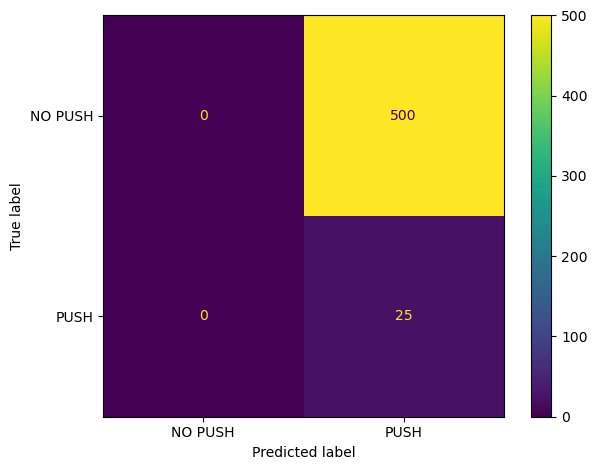

<Figure size 640x480 with 0 Axes>

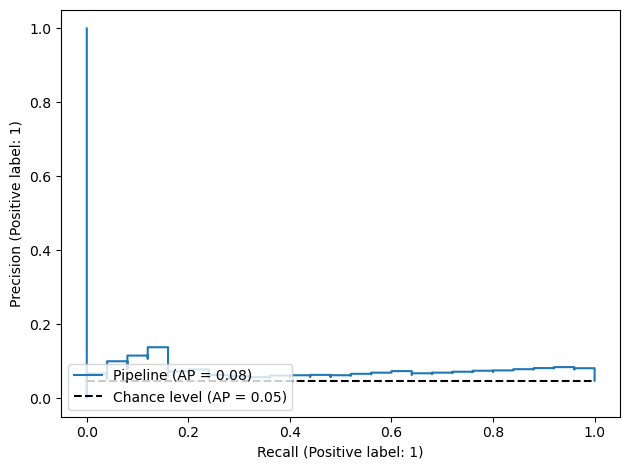

<Figure size 640x480 with 0 Axes>

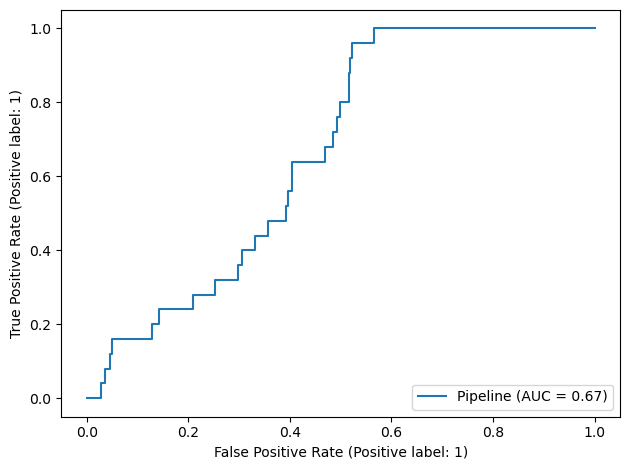

Test set:
 {'accuracy': 0.009900990099009901, 'balanced_accuracy': 0.5}
              precision    recall  f1-score   support

     NO_PUSH       0.00      0.00      0.00       900
        PUSH       0.01      1.00      0.02         9

    accuracy                           0.01       909
   macro avg       0.00      0.50      0.01       909
weighted avg       0.00      0.01      0.00       909



/opt/mambaforge/envs/witn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/mambaforge/envs/witn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/mambaforge/envs/witn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

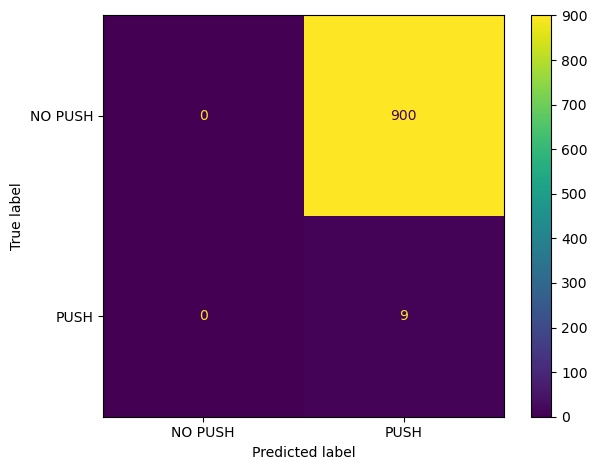

<Figure size 640x480 with 0 Axes>

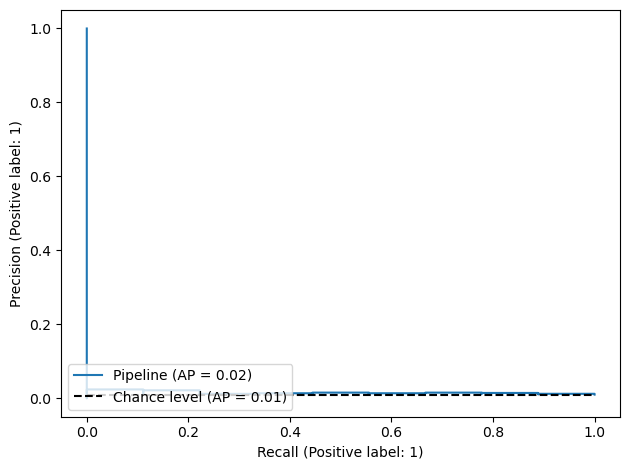

<Figure size 640x480 with 0 Axes>

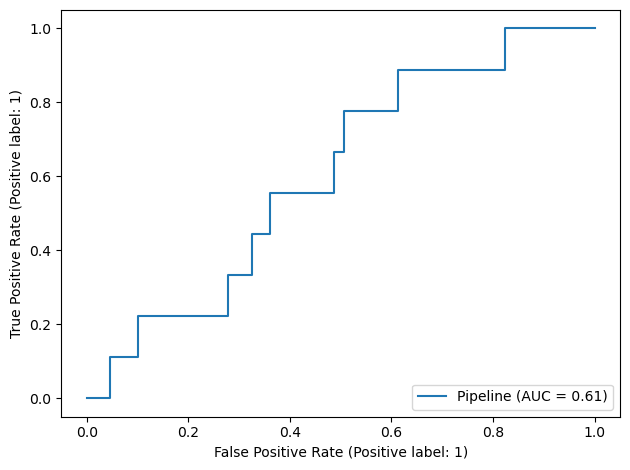

In [20]:
# SVM

pipeline_steps = list()
# PCA dim reduction
# pipeline_steps.append(
#     sklearn.decomposition.PCA(
#         n_components=64,
#         whiten=True,
#         random_state=rng.integers(low=0, high=4294967295),
#     )
# )

# Model definition & training
model = sklearn.svm.SVC(
    kernel="rbf",
    class_weight="balanced",
    cache_size=1000,
    verbose=True,
    random_state=rng.integers(low=0, high=4294967295),
)
pipeline_steps.append(model)

pipeline = sklearn.pipeline.make_pipeline(*pipeline_steps, verbose=True)
pipeline.fit(x_train, y_train, svc__sample_weight=train_sample_weight)

# Evaluation
# Evaluate on training set.
y_pred_train = pipeline.predict(x_train)
train_acc = sklearn.metrics.accuracy_score(y_train, y_pred_train, normalize=True)
train_balance_acc = sklearn.metrics.balanced_accuracy_score(y_train, y_pred_train)
print("Train set:\n", {"accuracy": train_acc, "balanced_accuracy": train_balance_acc})
print(
    sklearn.metrics.classification_report(
        y_train, y_pred_train, target_names=["NO_PUSH", "PUSH"]
    )
)
plt.clf()
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train, display_labels=["NO PUSH", "PUSH"]
)
plt.show()
plt.clf()
sklearn.metrics.PrecisionRecallDisplay.from_estimator(
    pipeline, X=x_train, y=y_train, pos_label=PUSH, plot_chance_level=True
)
plt.show()
plt.clf()
sklearn.metrics.RocCurveDisplay.from_estimator(
    pipeline, X=x_train, y=y_train, pos_label=PUSH
)
plt.show()

print("=" * 100)

# Test set
y_pred_test = pipeline.predict(x_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_pred_test, normalize=True)
test_balance_acc = sklearn.metrics.balanced_accuracy_score(y_test, y_pred_test)
print("Test set:\n", {"accuracy": test_acc, "balanced_accuracy": test_balance_acc})
print(
    sklearn.metrics.classification_report(
        y_test, y_pred_test, target_names=["NO_PUSH", "PUSH"]
    )
)
plt.clf()
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test, display_labels=["NO PUSH", "PUSH"]
)
plt.show()
plt.clf()
sklearn.metrics.PrecisionRecallDisplay.from_estimator(
    pipeline, X=x_test, y=y_test, pos_label=PUSH, plot_chance_level=True
)
plt.show()
plt.clf()
sklearn.metrics.RocCurveDisplay.from_estimator(
    pipeline, X=x_test, y=y_test, pos_label=PUSH
)
plt.show()

Binning 0.013 GB of training data: 1.574 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 7 leaves, max depth = 4, in 0.020s
[2/1000] 1 tree, 8 leaves, max depth = 4, in 0.020s
[3/1000] 1 tree, 7 leaves, max depth = 4, in 0.021s
[4/1000] 1 tree, 7 leaves, max depth = 4, in 0.025s
[5/1000] 1 tree, 8 leaves, max depth = 4, in 0.020s
[6/1000] 1 tree, 6 leaves, max depth = 3, in 0.020s
[7/1000] 1 tree, 8 leaves, max depth = 4, in 0.021s
[8/1000] 1 tree, 7 leaves, max depth = 4, in 0.017s
[9/1000] 1 tree, 7 leaves, max depth = 3, in 0.022s
[10/1000] 1 tree, 8 leaves, max depth = 4, in 0.020s
[11/1000] 1 tree, 8 leaves, max depth = 4, in 0.020s
[12/1000] 1 tree, 8 leaves, max depth = 4, in 0.022s
[13/1000] 1 tree, 7 leaves, max depth = 3, in 0.019s
[14/1000] 1 tree, 7 leaves, max depth = 4, in 0.023s
[15/1000] 1 tree, 7 leaves, max depth = 3, in 0.017s
[16/1000] 1 tree, 7 leaves, max depth = 4, in 0.022s
[17/1000] 1 tree, 7 leaves, max depth = 4, in 0.016s
[18/1000] 1 tree, 7 leaves, max 

<Figure size 640x480 with 0 Axes>

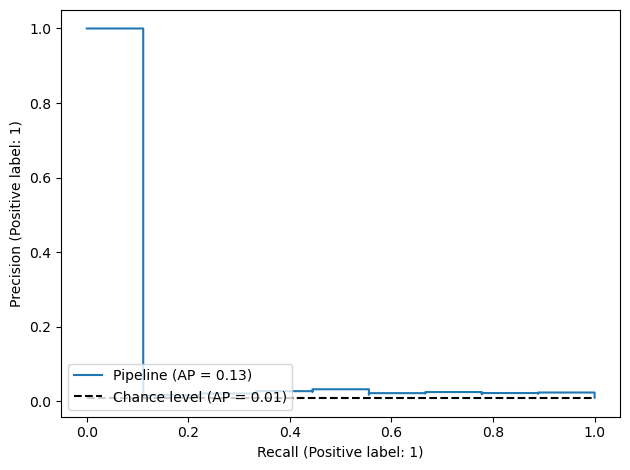

<Figure size 640x480 with 0 Axes>

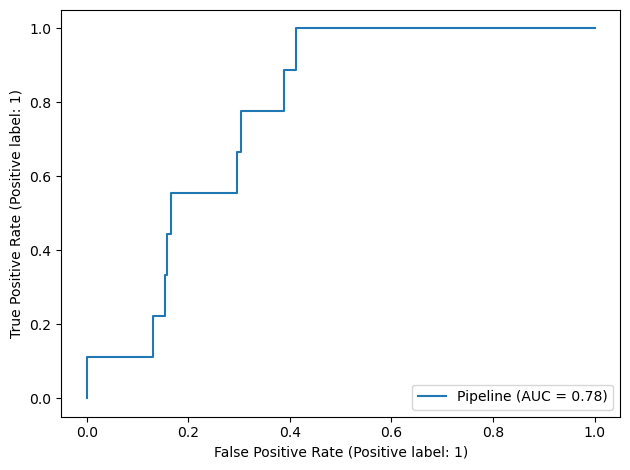

In [22]:
# Random forest

pipeline_steps = list()
# PCA dim reduction
# pipeline_steps.append(
#     sklearn.decomposition.PCA(
#         n_components=64*5,
#         whiten=True,
#         random_state=rng.integers(low=0, high=4294967295),
#     )
# )

# Model definition & training
model = sklearn.ensemble.HistGradientBoostingClassifier(
    class_weight={NO_PUSH: train_neg_weight, PUSH: train_pos_weight},
    max_iter=1000,
    l2_regularization=True,
    random_state=rng.integers(low=0, high=4294967295),
    verbose=True,
)
pipeline_steps.append(model)

pipeline = sklearn.pipeline.make_pipeline(*pipeline_steps)
pipeline.fit(x_train, y_train)
print(flush=True)
time.sleep(2)
# Evaluation
# Evaluate on training set.
y_pred_train = pipeline.predict(x_train)
train_acc = sklearn.metrics.accuracy_score(y_train, y_pred_train, normalize=True)
train_balance_acc = sklearn.metrics.balanced_accuracy_score(y_train, y_pred_train)
print("Train set:\n", {"accuracy": train_acc, "balanced_accuracy": train_balance_acc})
print(
    sklearn.metrics.classification_report(
        y_train, y_pred_train, target_names=["NO_PUSH", "PUSH"]
    )
)

print(flush=True)
time.sleep(2)
# plt.clf()
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
#     y_train, y_pred_train, display_labels=["NO PUSH", "PUSH"]
# )
# plt.show()
# plt.clf()
# sklearn.metrics.PrecisionRecallDisplay.from_estimator(
#     pipeline, X=x_train, y=y_train, pos_label=PUSH, plot_chance_level=True
# )
# plt.show()
# plt.clf()
# sklearn.metrics.RocCurveDisplay.from_estimator(
#     pipeline, X=x_train, y=y_train, pos_label=PUSH
# )
# plt.show()
print("=" * 100)

# Test set
y_pred_test = pipeline.predict(x_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_pred_test, normalize=True)
test_balance_acc = sklearn.metrics.balanced_accuracy_score(y_test, y_pred_test)
print("Test set:\n", {"accuracy": test_acc, "balanced_accuracy": test_balance_acc})
print(
    sklearn.metrics.classification_report(
        y_test, y_pred_test, target_names=["NO_PUSH", "PUSH"]
    )
)
print(flush=True)
# plt.clf()
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
#     y_test, y_pred_test, display_labels=["NO PUSH", "PUSH"]
# )
# plt.show()
plt.clf()
sklearn.metrics.PrecisionRecallDisplay.from_estimator(
    pipeline, X=x_test, y=y_test, pos_label=PUSH, plot_chance_level=True
)
plt.show()
plt.clf()
sklearn.metrics.RocCurveDisplay.from_estimator(
    pipeline, X=x_test, y=y_test, pos_label=PUSH
)
plt.show();